In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import joblib
from datetime import datetime
from sklearn.neural_network import MLPClassifier
import os
from sklearn.metrics import confusion_matrix, cohen_kappa_score, mean_squared_error, r2_score
from sklearn.metrics import make_scorer
from catboost import CatBoostClassifier

df = pd.read_csv('../data/event_prediction_dataset/event_prediction_dataset_V4.csv', low_memory=False)


cols_to_convert = [ 'description', 'bat_speed', 'swing_length', 'pitch_type', 'release_speed', 'release_pos_x',
    'release_pos_y', 'release_pos_z', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
    'effective_speed', 'release_spin_rate', 'release_extension', 'plate_x', 'plate_z', 'p_throws',
    'balls', 'strikes', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot',
    'home_score', 'away_score', 'at_bat_number', 'pitch_number', 'game_pk', 'bat_win_exp',
    'zone_level', 'hc_x_level', 'hc_y_level', 'hit_distance_sc_level',
    'estimated_ba_using_speedangle_level', 'babip_value_level', 'iso_value_level',
    'bat_speed_level', 'swing_length_level', 'stand', 'P_bb_type_fly_ball',
    'P_bb_type_ground_ball', 'P_bb_type_line_drive', 'P_bb_type_popup', 'P_bb_type_other',
    'P_launch_speed_angle_0', 'P_launch_speed_angle_1', 'P_launch_speed_angle_2',
    'P_launch_speed_angle_3', 'P_launch_speed_angle_4', 'P_launch_speed_angle_5',
    'P_launch_speed_angle_6', 'bb_type', 'batter', 'estimated_slg_using_speedangle_level',
    'P_estimated_slg_using_speedangle_level', 'if_fielding_alignment', 'of_fielding_alignment',
    'home_score_diff', 'home_win_exp', 'age_pit', 'n_thruorder_pitcher',
    'n_priorpa_thisgame_player_at_bat', 'age_bat', 'batter_days_since_prev_game',
    'prev_batter_type_1', 'prev_bat_win_exp_1', 'prev_batter_type_2', 'prev_bat_win_exp_2',
    'prev_batter_type_3', 'prev_bat_win_exp_3', 'prev_batter_type_4', 'prev_bat_win_exp_4',
    'prev_batter_type_5', 'prev_bat_win_exp_5'
]

for col in cols_to_convert:
    if df[col].map(type).eq(str).any():
        df[col] = df[col].str.extract('([0-9.-]+)', expand=False)
        df[col] = df[col].astype(float)
df['prev_bat_win_exp_1'] = df['prev_bat_win_exp_1'].fillna(0)
df['prev_bat_win_exp_2'] = df['prev_bat_win_exp_2'].fillna(0)
df['prev_bat_win_exp_3'] = df['prev_bat_win_exp_3'].fillna(0)
df['prev_bat_win_exp_4'] = df['prev_bat_win_exp_4'].fillna(0)
df['prev_bat_win_exp_5'] = df['prev_bat_win_exp_5'].fillna(0)

df = df.dropna()
df = df.drop(columns=['batter', 'game_pk', 'bat_win_exp'])

In [8]:
values_to_remove = [0, 1, 4, 6, 9, 12]
df = df[~df['description'].isin(values_to_remove)]
df = df.reset_index(drop=True)

X = df.drop(columns=['description'])
y = df['description']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Finished standardizing data")

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
print("Finished Splitting data")

Finished standardizing data
Finished Splitting data


In [5]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    # 'activation': ['relu', 'tanh', 'logistic'],
    # 'solver': ['adam', 'sgd'],
    # 'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200, 500, 1000],
}

pca_components_list = [30,50, None]
pca_accuracies = []
best_accuracy = 0
best_model = None
best_pca_components = 0

print("Starting PCA & GridSearchCV")

for n_components in pca_components_list:
    print('n_components:', n_components)
    if n_components is not None:
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
    else:
        X_train_pca, X_test_pca = X_train, X_test

    mlp_model = MLPClassifier(random_state=42)
    grid_search = GridSearchCV(mlp_model, param_grid, cv=2, scoring='accuracy', n_jobs=1, verbose=3)

    grid_search.fit(X_train_pca, y_train)

    y_pred = grid_search.best_estimator_.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    pca_accuracies.append((n_components, accuracy))

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = grid_search.best_estimator_
        best_pca_components = n_components

Starting PCA & GridSearchCV
n_components: 30
Fitting 2 folds for each of 9 candidates, totalling 18 fits


/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END hidden_layer_sizes=(50,), max_iter=200;, score=0.757 total time= 2.0min


/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END hidden_layer_sizes=(50,), max_iter=200;, score=0.758 total time= 2.1min
[CV 1/2] END hidden_layer_sizes=(50,), max_iter=500;, score=0.756 total time= 3.8min
[CV 2/2] END hidden_layer_sizes=(50,), max_iter=500;, score=0.762 total time= 4.0min
[CV 1/2] END hidden_layer_sizes=(50,), max_iter=1000;, score=0.756 total time= 3.4min
[CV 2/2] END hidden_layer_sizes=(50,), max_iter=1000;, score=0.762 total time= 4.3min


/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END hidden_layer_sizes=(100,), max_iter=200;, score=0.739 total time= 2.9min


/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END hidden_layer_sizes=(100,), max_iter=200;, score=0.737 total time= 2.9min
[CV 1/2] END hidden_layer_sizes=(100,), max_iter=500;, score=0.742 total time= 5.5min
[CV 2/2] END hidden_layer_sizes=(100,), max_iter=500;, score=0.742 total time= 6.2min
[CV 1/2] END hidden_layer_sizes=(100,), max_iter=1000;, score=0.742 total time= 4.9min
[CV 2/2] END hidden_layer_sizes=(100,), max_iter=1000;, score=0.742 total time= 6.8min


/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END hidden_layer_sizes=(50, 50), max_iter=200;, score=0.744 total time= 3.3min


/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END hidden_layer_sizes=(50, 50), max_iter=200;, score=0.747 total time= 3.2min
[CV 1/2] END hidden_layer_sizes=(50, 50), max_iter=500;, score=0.745 total time= 4.8min
[CV 2/2] END hidden_layer_sizes=(50, 50), max_iter=500;, score=0.748 total time= 3.8min
[CV 1/2] END hidden_layer_sizes=(50, 50), max_iter=1000;, score=0.745 total time= 5.1min
[CV 2/2] END hidden_layer_sizes=(50, 50), max_iter=1000;, score=0.748 total time= 3.6min
n_components: 50
Fitting 2 folds for each of 9 candidates, totalling 18 fits


/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END hidden_layer_sizes=(50,), max_iter=200;, score=0.805 total time= 1.8min


/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END hidden_layer_sizes=(50,), max_iter=200;, score=0.807 total time= 1.8min
[CV 1/2] END hidden_layer_sizes=(50,), max_iter=500;, score=0.804 total time= 2.1min
[CV 2/2] END hidden_layer_sizes=(50,), max_iter=500;, score=0.806 total time= 2.6min
[CV 1/2] END hidden_layer_sizes=(50,), max_iter=1000;, score=0.804 total time= 2.6min
[CV 2/2] END hidden_layer_sizes=(50,), max_iter=1000;, score=0.806 total time= 3.0min


/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END hidden_layer_sizes=(100,), max_iter=200;, score=0.796 total time= 3.7min


/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END hidden_layer_sizes=(100,), max_iter=200;, score=0.792 total time= 3.6min
[CV 1/2] END hidden_layer_sizes=(100,), max_iter=500;, score=0.793 total time= 4.6min
[CV 2/2] END hidden_layer_sizes=(100,), max_iter=500;, score=0.793 total time= 5.8min
[CV 1/2] END hidden_layer_sizes=(100,), max_iter=1000;, score=0.793 total time= 4.9min
[CV 2/2] END hidden_layer_sizes=(100,), max_iter=1000;, score=0.793 total time= 5.6min


/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END hidden_layer_sizes=(50, 50), max_iter=200;, score=0.792 total time= 3.3min


/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END hidden_layer_sizes=(50, 50), max_iter=200;, score=0.794 total time= 3.3min
[CV 1/2] END hidden_layer_sizes=(50, 50), max_iter=500;, score=0.790 total time= 3.6min
[CV 2/2] END hidden_layer_sizes=(50, 50), max_iter=500;, score=0.784 total time= 4.0min
[CV 1/2] END hidden_layer_sizes=(50, 50), max_iter=1000;, score=0.790 total time= 3.7min
[CV 2/2] END hidden_layer_sizes=(50, 50), max_iter=1000;, score=0.784 total time= 3.8min
n_components: None
Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV 1/2] END hidden_layer_sizes=(50,), max_iter=200;, score=0.804 total time= 1.9min


/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END hidden_layer_sizes=(50,), max_iter=200;, score=0.808 total time= 1.9min
[CV 1/2] END hidden_layer_sizes=(50,), max_iter=500;, score=0.804 total time= 1.9min
[CV 2/2] END hidden_layer_sizes=(50,), max_iter=500;, score=0.808 total time= 2.6min
[CV 1/2] END hidden_layer_sizes=(50,), max_iter=1000;, score=0.804 total time= 2.0min
[CV 2/2] END hidden_layer_sizes=(50,), max_iter=1000;, score=0.808 total time= 3.0min


/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END hidden_layer_sizes=(100,), max_iter=200;, score=0.787 total time= 3.6min


/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END hidden_layer_sizes=(100,), max_iter=200;, score=0.792 total time= 3.5min
[CV 1/2] END hidden_layer_sizes=(100,), max_iter=500;, score=0.787 total time= 5.2min
[CV 2/2] END hidden_layer_sizes=(100,), max_iter=500;, score=0.791 total time= 4.8min
[CV 1/2] END hidden_layer_sizes=(100,), max_iter=1000;, score=0.787 total time= 5.3min
[CV 2/2] END hidden_layer_sizes=(100,), max_iter=1000;, score=0.791 total time= 5.4min


/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END hidden_layer_sizes=(50, 50), max_iter=200;, score=0.785 total time= 3.5min


/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END hidden_layer_sizes=(50, 50), max_iter=200;, score=0.793 total time= 3.4min
[CV 1/2] END hidden_layer_sizes=(50, 50), max_iter=500;, score=0.791 total time= 4.0min
[CV 2/2] END hidden_layer_sizes=(50, 50), max_iter=500;, score=0.786 total time= 6.0min
[CV 1/2] END hidden_layer_sizes=(50, 50), max_iter=1000;, score=0.791 total time= 4.0min
[CV 2/2] END hidden_layer_sizes=(50, 50), max_iter=1000;, score=0.786 total time= 6.1min


50
Model saved to ../model/best_mlp_event_agent_prediction_model_20250109_135959.joblib


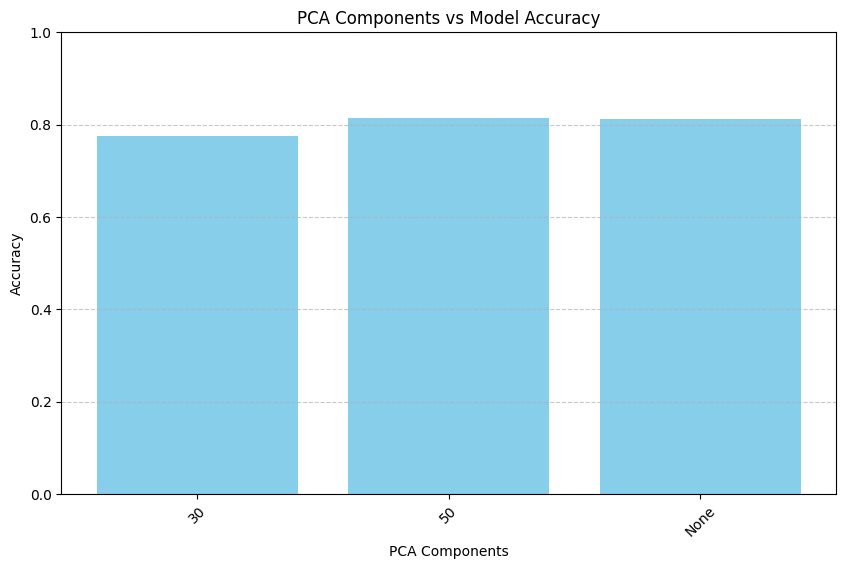

In [6]:
os.makedirs('../model', exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f"../model/best_mlp_event_agent_prediction_model_{timestamp}.joblib"

print(best_pca_components)
pca = PCA(n_components=best_pca_components)
pca.fit_transform(X_train)
joblib.dump({
    'model': best_model,
    'pca': pca if best_pca_components is not None else None,
    'n_components': best_pca_components,
    'accuracy': best_accuracy
}, model_filename)

print(f"Model saved to {model_filename}")

components, accuracies = zip(*pca_accuracies)
components = ['None' if c is None else str(c) for c in components]

plt.figure(figsize=(10, 6))
plt.bar(components, accuracies, color='skyblue')
plt.xlabel('PCA Components')
plt.ylabel('Accuracy')
plt.title('PCA Components vs Model Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [7]:
model_folder = os.path.join('..', 'model')
file_path = os.path.join(model_folder, model_filename)

saved_model = joblib.load(file_path)
loaded_model = saved_model['model']
loaded_pca = saved_model['pca']

if loaded_pca is not None:
    X_test_pca = loaded_pca.transform(X_test)
else:
    X_test_pca = X_test

y_pred_loaded = loaded_model.predict(X_test_pca)
loaded_accuracy = accuracy_score(y_test, y_pred_loaded)
print(f"Accuracy of loaded model: {loaded_accuracy:.4f}")

Accuracy of loaded model: 0.8136


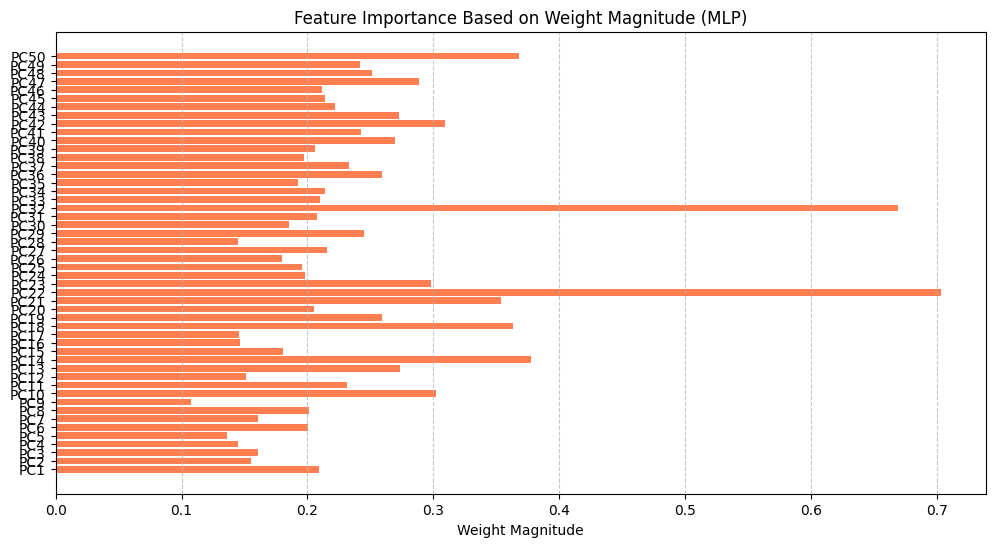

In [8]:
coefs = best_model.coefs_[0]  # First layer weights
feature_importance = np.mean(np.abs(coefs), axis=1)

features = X.columns if best_pca_components is None else [f'PC{i+1}' for i in range(best_pca_components)]
plt.figure(figsize=(12, 6))
plt.barh(features, feature_importance, color='coral')
plt.xlabel('Weight Magnitude')
plt.title('Feature Importance Based on Weight Magnitude (MLP)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


In [9]:
param_grid = {
    'iterations': [100, 200, 500],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    # 'l2_leaf_reg': [1, 3, 5, 7],
    # 'bagging_temperature': [0, 1, 2],
    # 'border_count': [32, 64, 128],
    # 'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
}

pca_components_list = [30,50,None]
pca_accuracies = []
best_accuracy = 0
best_model = None
best_pca_components = 0

for n_components in pca_components_list:
    print('n_components:', n_components)
    if n_components is not None:
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
    else:
        X_train_pca, X_test_pca = X_train, X_test

    cat_model = CatBoostClassifier(eval_metric='MultiClass', random_state=42, task_type='GPU', verbose=0)
    grid_search = GridSearchCV(cat_model, param_grid, cv=2, scoring='accuracy', n_jobs=1)

    grid_search.fit(X_train_pca, y_train)

    y_pred = grid_search.best_estimator_.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    pca_accuracies.append((n_components, accuracy))

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = grid_search.best_estimator_
        best_pca_components = n_components

n_components: 30
n_components: 50
n_components: None


None


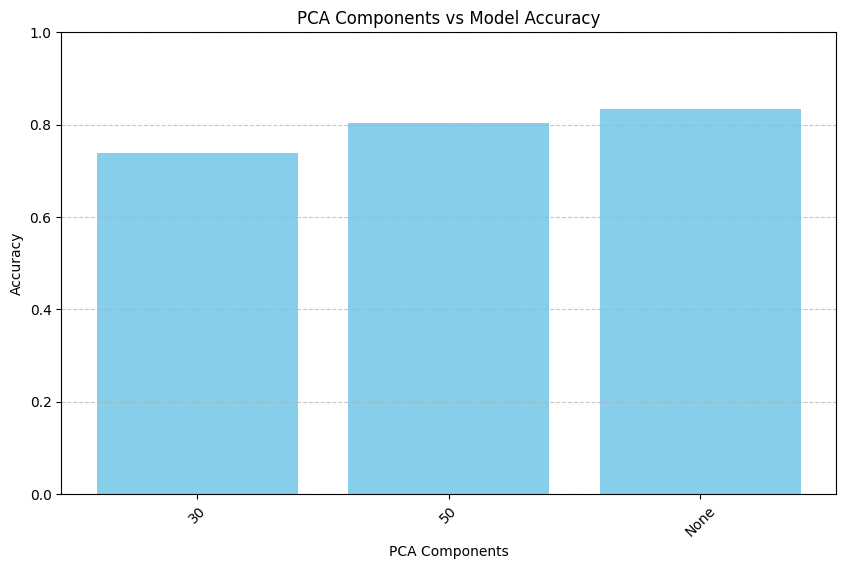

In [10]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f"../model/best_catboost_batter_agent_prediction_model_{timestamp}.joblib"
model_folder = os.path.join('..', 'model')
os.makedirs(model_folder, exist_ok=True)

model_filename = f"best_catboost_event_agent_prediction_model_{timestamp}.joblib"
file_path = os.path.join(model_folder, model_filename)

print(best_pca_components)
pca = PCA(n_components=best_pca_components)
pca.fit_transform(X_train)
joblib.dump({
    'model': best_model,
    'pca': pca if best_pca_components is not None else None,
    'n_components': best_pca_components,
    'accuracy': best_accuracy
}, file_path)



components, accuracies = zip(*pca_accuracies)
components = ['None' if c is None else str(c) for c in components]

plt.figure(figsize=(10, 6))
plt.bar(components, accuracies, color='skyblue')
plt.xlabel('PCA Components')
plt.ylabel('Accuracy')
plt.title('PCA Components vs Model Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


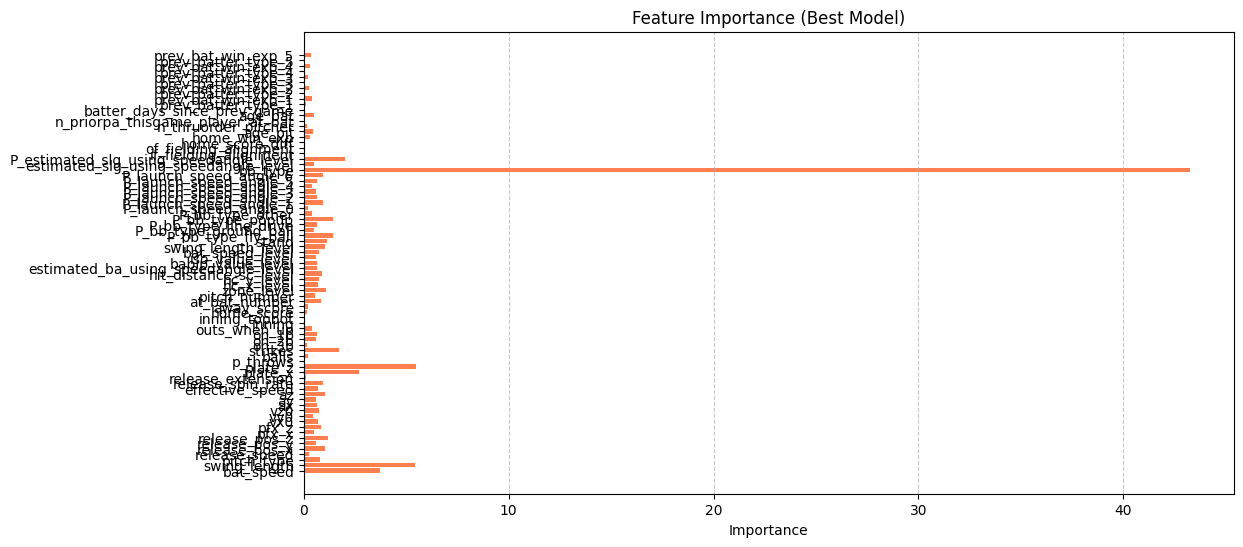

Best accuracy: 0.8342 with PCA components: None
Accuracy of loaded model: 0.8342


In [11]:
feature_importances = best_model.feature_importances_

if best_pca_components is None:
    features = X.columns
else:
    features = [f'PC{i+1}' for i in range(best_pca_components)]

plt.figure(figsize=(12, 6))
plt.barh(features, feature_importances, color='coral')
plt.xlabel('Importance')
plt.title('Feature Importance (Best Model)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


print(f"Best accuracy: {best_accuracy:.4f} with PCA components: {best_pca_components}")


saved_model = joblib.load(file_path)
loaded_model = saved_model['model']
loaded_pca = saved_model['pca']

if loaded_pca is not None:
    X_test_pca = loaded_pca.transform(X_test)
else:
    X_test_pca = X_test

y_pred_loaded = loaded_model.predict(X_test_pca)
loaded_accuracy = accuracy_score(y_test, y_pred_loaded)
print(f"Accuracy of loaded model: {loaded_accuracy:.4f}")